<a href="https://colab.research.google.com/github/rubygitflow/GANs/blob/master/University_of_Artificial_Intelligence_NLP_HomeWork_7_Pro_Text2Images_(COCO_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP.Lesson 7.2.Text2Images

**COCO categories:**

person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image

import imageio
from tqdm.notebook import tqdm
from skimage.transform import resize

import os
import pickle
import random
import time

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, \
     UpSampling2D, Conv2D, Activation, concatenate, Flatten, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Checking the GPU

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import os
import psutil
import humanize
import GPUtil as GPU
GPUs = GPU.getGPUs()
if len(GPUs)>0:
  gpu = GPUs[0]
else:
  print('GPU turned off')
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM FREE: "+humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  if len(GPUs)>0:
    print("Gen RAM FREE: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    print("GPU Model: " + gpu.name)

printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=eff9309758d7230e9c325d84f4a782e0b91d5c1aca091502841c82172357a5ca
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM FREE: 12.7 GB  | Proc size: 371.8 MB
Gen RAM FREE: 15079MB | Used: 0MB | Util   0% | Total 15079MB
GPU Model: Tesla T4


#Downloading COCO-dataset

We are loocking for "Common Objects in Context" dataset on https://cocodataset.org/#download

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2020-09-20 22:37:24--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.93.179
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.93.179|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  31.8MB/s    in 7.8s    

2020-09-20 22:37:32 (30.9 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
!unzip annotations_trainval2017.zip

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


We only need descriptions of captions and instances.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/My\ Drive/Базы/NLP/load_class.py -d /content/load_class.py

In [ ]:
from load_class import load_class

In [ ]:
# run the module function that downloads the dataset from COCO by the specified class and category
load_class('laptop', 'train2017') 

loading annotations into memory...
Done (t=14.37s)
creating index...
index created!
loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
COCO categories: 
person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush

----------------------------------------
Selected category -  laptop




Skipped files due to errors:  0
After the mask, the number of downloaded files = the number of descriptions in csv: True
Total downloaded images of a specific class:  3524


# Preparing dataset

In [ ]:
df_bbs = pd.read_csv('/content/data/cat_ann/ann_BB_train2017.csv', index_col=0)

In [ ]:
df_bbs.head()

,filename,idx,width,height,class,xmin,ymin,xmax,ymax
0,000000092173.jpg,92173,640,478,laptop,45,144,209,281
1,000000441415.jpg,441415,640,480,laptop,388,252,447,275
2,000000150342.jpg,150342,640,427,laptop,198,170,290,221
3,000000298197.jpg,298197,481,640,laptop,123,359,454,484
4,000000540926.jpg,540926,427,640,laptop,56,213,426,468


In [ ]:
# Make sure that the boundbox is inside the image frame
(df_bbs.ymax == df_bbs.height).any()

False

In [ ]:
img_folder = '/content/data/cat/'

In [ ]:
bad_imgs = [] # prepare a list for "broken" images
for i in tqdm(range(df_bbs.shape[0])): # go through all the pictures
  filename = df_bbs.filename[i] # take the name
  img_full_path = img_folder+filename

  # get the boundbox coordinates 
  xmin = df_bbs.xmin[i]
  xmax = df_bbs.xmax[i]
  ymin = df_bbs.ymin[i]
  ymax = df_bbs.ymax[i]
  try: # if the image is not broken, then crop it by boundbox and perform a resize
    img = img_to_array(load_img(img_full_path))[ymin:ymax, xmin:xmax]
    imageio.imsave(img_full_path, resize(img, (64,64)).astype('uint8'))
  except: # otherwise, we remember the index of the bit image
    bad_imgs.append(i)

In [ ]:
bad_imgs

In [ ]:
len(bad_imgs)

1421

In [ ]:
df_bbs.drop(index=bad_imgs, inplace=True) # deleting rows with broken images from the table

In [ ]:
df_desc = pd.read_csv('/content/data/cat_ann/ann_description_train2017.csv', index_col=0)

In [ ]:
df_desc

,idx,description
0,79472,Office space with office equipment on desk top.
1,79472,A hope office setup of computers and printers.
2,79472,"a home office with laptop, printer, scanner, a..."
3,79472,The computer desk in the corner is by a window.
4,493753,An office desk holding multiple computers and ...
...,...,...
17619,174896,A computer is sitting on a table near a bunch ...
17620,174896,A table with someone's lunch with wine and a l...
17621,312398,A couple of men having conversation at a dinin...
17622,137552,A bouquet of roses sits on the desk next to th...


In [ ]:
data = df_bbs.merge(df_desc, on='idx') # combining tables with information on the image and information on the description

In [ ]:
data.head(10)

,filename,idx,width,height,class,xmin,ymin,xmax,ymax,description
0,000000092173.jpg,92173,640,478,laptop,45,144,209,281,A black and white cat laying on top of a desk.
1,000000092173.jpg,92173,640,478,laptop,45,144,209,281,THERE IS A CAT THAT IS LYING DOWN
2,000000092173.jpg,92173,640,478,laptop,45,144,209,281,there is a cat laying on a pillow on top of a ...
3,000000092173.jpg,92173,640,478,laptop,45,144,209,281,a cat lying on a green piece of material on a ...
4,000000092173.jpg,92173,640,478,laptop,45,144,209,281,A black and white cat laying on the carrying c...
5,000000441415.jpg,441415,640,480,laptop,388,252,447,275,A wooden table sitting under a picture with wo...
6,000000441415.jpg,441415,640,480,laptop,388,252,447,275,A room with a very small dining table and chairs.
7,000000441415.jpg,441415,640,480,laptop,388,252,447,275,\nAn empty table that is set up for dining.
8,000000441415.jpg,441415,640,480,laptop,388,252,447,275,A table and some chairs in a room.
9,000000441415.jpg,441415,640,480,laptop,388,252,447,275,There is two laptops on the table and bag on o...


In [ ]:
len(data)

17749

In [ ]:
image_size = 64

X_train = np.zeros((data.shape[0], image_size, image_size, 3), dtype='uint8') # preparing an array of images: Batch X height X width X channels
for i, filename in enumerate(data.filename): # go through all the images
  X_train[i]=img_to_array(load_img(img_folder+filename)).astype('uint8') # saving the next image

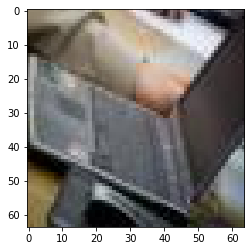

In [ ]:
plt.imshow(X_train[20])

In [ ]:
wiki = hub.load("https://tfhub.dev/google/Wiki-words-250/2") # downloading the language model

In [ ]:
embeddings = wiki(data.description) # get a set of embeddings descriptions of the image

In [ ]:
embeddings

<tf.Tensor: shape=(17749, 250), dtype=float32, numpy=
array([[-0.07708009, -0.22240314, -0.0360272 , ..., -0.06858585,
         0.06041828, -0.0144395 ],
       [ 0.04019657, -0.14249563,  0.09882458, ...,  0.04973515,
         0.10820542, -0.11408751],
       [-0.09293577, -0.26933593,  0.03780282, ..., -0.07778566,
         0.00845432, -0.02646738],
       ...,
       [-0.11118564, -0.18998542, -0.02178879, ..., -0.03083483,
         0.13685887, -0.01456234],
       [-0.05420443, -0.15994929, -0.06692348, ..., -0.03221947,
         0.07927821, -0.02041932],
       [-0.08674592, -0.27133563,  0.05818712, ...,  0.01322102,
         0.06286572, -0.02545526]], dtype=float32)>

# Modelling

In [ ]:
def generate_c(x): # reparametrisation trick
    mean = x[:, :128]
    log_sigma = x[:, 128:]
    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean
    return c
  
  
def build_embedding_compressor_model(): # embedding compression
    input_layer = Input(shape=(embeddings.shape[1],))
    x = Dense(128)(input_layer)
    x = ReLU()(x)

    model = Model(inputs=[input_layer], outputs=[x])
    return model
  
def build_stage1_generator(): # generator on stage 1
    input_layer = Input(shape=(embeddings.shape[1],))
    x = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(x)

    c = Lambda(generate_c)(mean_logsigma)

    input_layer2 = Input(shape=(100,))

    gen_input = Concatenate(axis=1)([c, input_layer2])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = ReLU()(x)

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, input_layer2], outputs=[x, mean_logsigma])
    return stage1_gen

def build_stage1_discriminator(): # discriminator that accepts an image and embedding an image description
    input_layer = Input(shape=(64, 64, 3))

    x = Conv2D(64, (4, 4),
               padding='same', strides=2,
               input_shape=(64, 64, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    input_layer2 = Input(shape=(4, 4, 128))

    merged_input = concatenate([x, input_layer2])

    x2 = Conv2D(64 * 8, kernel_size=1,
                padding="same", strides=1)(merged_input)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1)(x2)
    x2 = Activation('sigmoid')(x2)

    stage1_dis = Model(inputs=[input_layer, input_layer2], outputs=[x2])
    return stage1_dis
  
def build_adversarial_model(gen_model, dis_model): # 
    input_layer = Input(shape=(embeddings.shape[1],))
    input_layer2 = Input(shape=(100,))
    input_layer3 = Input(shape=(4, 4, 128))

    x, mean_logsigma = gen_model([input_layer, input_layer2])

    dis_model.trainable = False
    valid = dis_model([x, input_layer3])

    model = Model(inputs=[input_layer, input_layer2, input_layer3], outputs=[valid, mean_logsigma])
    return model

In [ ]:
def KL_loss(y_true, y_pred): #  Kullback-Leibler Distance
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss
    

def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)

In [ ]:
def save_rgb_img(img, path): # save the image by the path
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()

# Training

In [ ]:
# hyperparameters
data_dir = "/content/cat/"
batch_size = 64
z_dim = 100
stage1_generator_lr = 0.0002
stage1_discriminator_lr = 0.0002
stage1_lr_decay_step = 600
epochs = 705
condition_dim = 128
path = "/content/drive/My Drive/Базы/NLP/Laptop/results/"

In [ ]:
# creating optimizers
dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)



stage1_dis = build_stage1_discriminator()
stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

stage1_gen = build_stage1_generator()
stage1_gen.compile(loss="mse", optimizer=gen_optimizer)

embedding_compressor_model = build_embedding_compressor_model()
embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")

adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                          optimizer=gen_optimizer, metrics=None)


# creating labels for training
# label smoothing
real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
fake_labels = np.zeros((batch_size, 1), dtype=float) + 0.1

In [ ]:
Z_NOISE = np.random.normal(0, 1, size=(10, z_dim)) # constant noise vector for tracking progress
os.makedirs('results', exist_ok='True')

for epoch in range(epochs):
    print("========================================")
    print("Epoch is:", epoch)
    print("Number of batches", int(data.shape[0] / batch_size))

    gen_losses = []
    dis_losses = []


    number_of_batches = int(data.shape[0] / batch_size)
    for index in range(number_of_batches):
        print("Batch:{}".format(index+1))
        
        # Create a noise vector
        z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
        image_batch = X_train[index * batch_size:(index + 1) * batch_size]
        embedding_batch = embeddings[index * batch_size:(index + 1) * batch_size]
        image_batch = (image_batch - 127.5) / 127.5

        # Generate fake images
        fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)

        # Generate compressed embeddings 
        compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch)
        compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim))
        compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

        # Train the discriminator model
        dis_loss_real = stage1_dis.train_on_batch([image_batch, compressed_embedding],
                                                  np.reshape(real_labels, (batch_size, 1)))
        dis_loss_fake = stage1_dis.train_on_batch([fake_images, compressed_embedding],
                                                  np.reshape(fake_labels, (batch_size, 1)))
        dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)], compressed_embedding[1:]],
                                                    np.reshape(fake_labels[1:], (batch_size-1, 1)))

        d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

        print("d_loss_real:{}".format(dis_loss_real))
        print("d_loss_fake:{}".format(dis_loss_fake))
        print("d_loss_wrong:{}".format(dis_loss_wrong))
        print("d_loss:{}".format(d_loss))

        # Train the adversarial model
        g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])
        print("g_loss:{}".format(g_loss))

        dis_losses.append(d_loss)
        gen_losses.append(g_loss)

    # Saving the models
    if epoch % 20 == 0:
      stage1_gen.save_weights(path+"stage1_gen.h5")
      stage1_dis.save_weights(path+"stage1_dis.h5")

    
    # Generate and save images after every 2nd epoch
    if epoch % 2 == 0:
        
        embedding_batch = embeddings[-10:]
        fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, Z_NOISE])

        # Save images
        for i, img in enumerate(fake_images):
            save_rgb_img(img, path+"results/gen_{}_{}.png".format(epoch, i))

# Saving the models
stage1_gen.save_weights(path+"stage1_gen.h5")
stage1_dis.save_weights(path+"stage1_dis.h5")

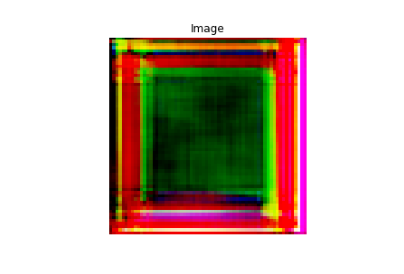

In [ ]:
image = np.array(Image.open(path+'results/gen_0_0.png'), dtype=np.uint8)
plt.figure(figsize=(7,7))
plt.axis("off")
plt.imshow(image)
plt.show()

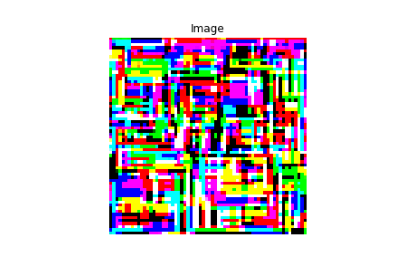

In [ ]:
image = np.array(Image.open(path+'results/gen_478_9.png'), dtype=np.uint8)
plt.figure(figsize=(7,7))
plt.axis("off")
plt.imshow(image)
plt.show()